In [242]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from matplotlib.pyplot import subplots

from ISLP import load_data

## The below is not needed, simply the authors removing complexity 
## for those uncomfortable with the methods used by statsmodels or scikit-learn
from ISLP.models import (ModelSpec as MS, summarize , poly)

In [243]:
# ISLP.load_data returns a pd.DataFrame
boston = load_data("Boston")
list(boston.columns)

['crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'lstat',
 'medv']

In [244]:
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [245]:
def scatter_all(df, fig_size:int = 10, plot_types: dict = None):
    """Takes a pandas.DataFrame() and creates a scatter plot to compare
    all columns within the pandas.DataFrame(). It plots the matplotlib.pyplot.subplot.

    Args:
        df (_type_): _description_
        ig_size (int, optional): size of the matplotlib.pyplot.subplot out put. Defaults to 10.
        plot_types (dict, optional): #TODO A dictionary where the key is the list of columns to plot [x,y] and the value is the type of plot. This will allow for users to make a box plot if appropriate. Defaults to None.

    Returns:
        _type_: _description_
    """
    plot_size = len(df.columns)
    plot_count = 1
    fig = plt.figure(figsize=(fig_size, fig_size))
    for i in range(plot_size):
        for j in range(plot_size):
            plt.subplot(plot_size, plot_size, plot_count)
            if i == j:
                plt.text(0.3, 0.3,list(df.columns)[i])
            else:
                plt.scatter(df.iloc[:,j], df.iloc[:,i])
            if j == 0:
                plt.ylabel(list(df.columns)[i])
            if i == (plot_size - 1):
                plt.xlabel(list(df.columns)[j])
            plot_count+=1
    return plt.show()

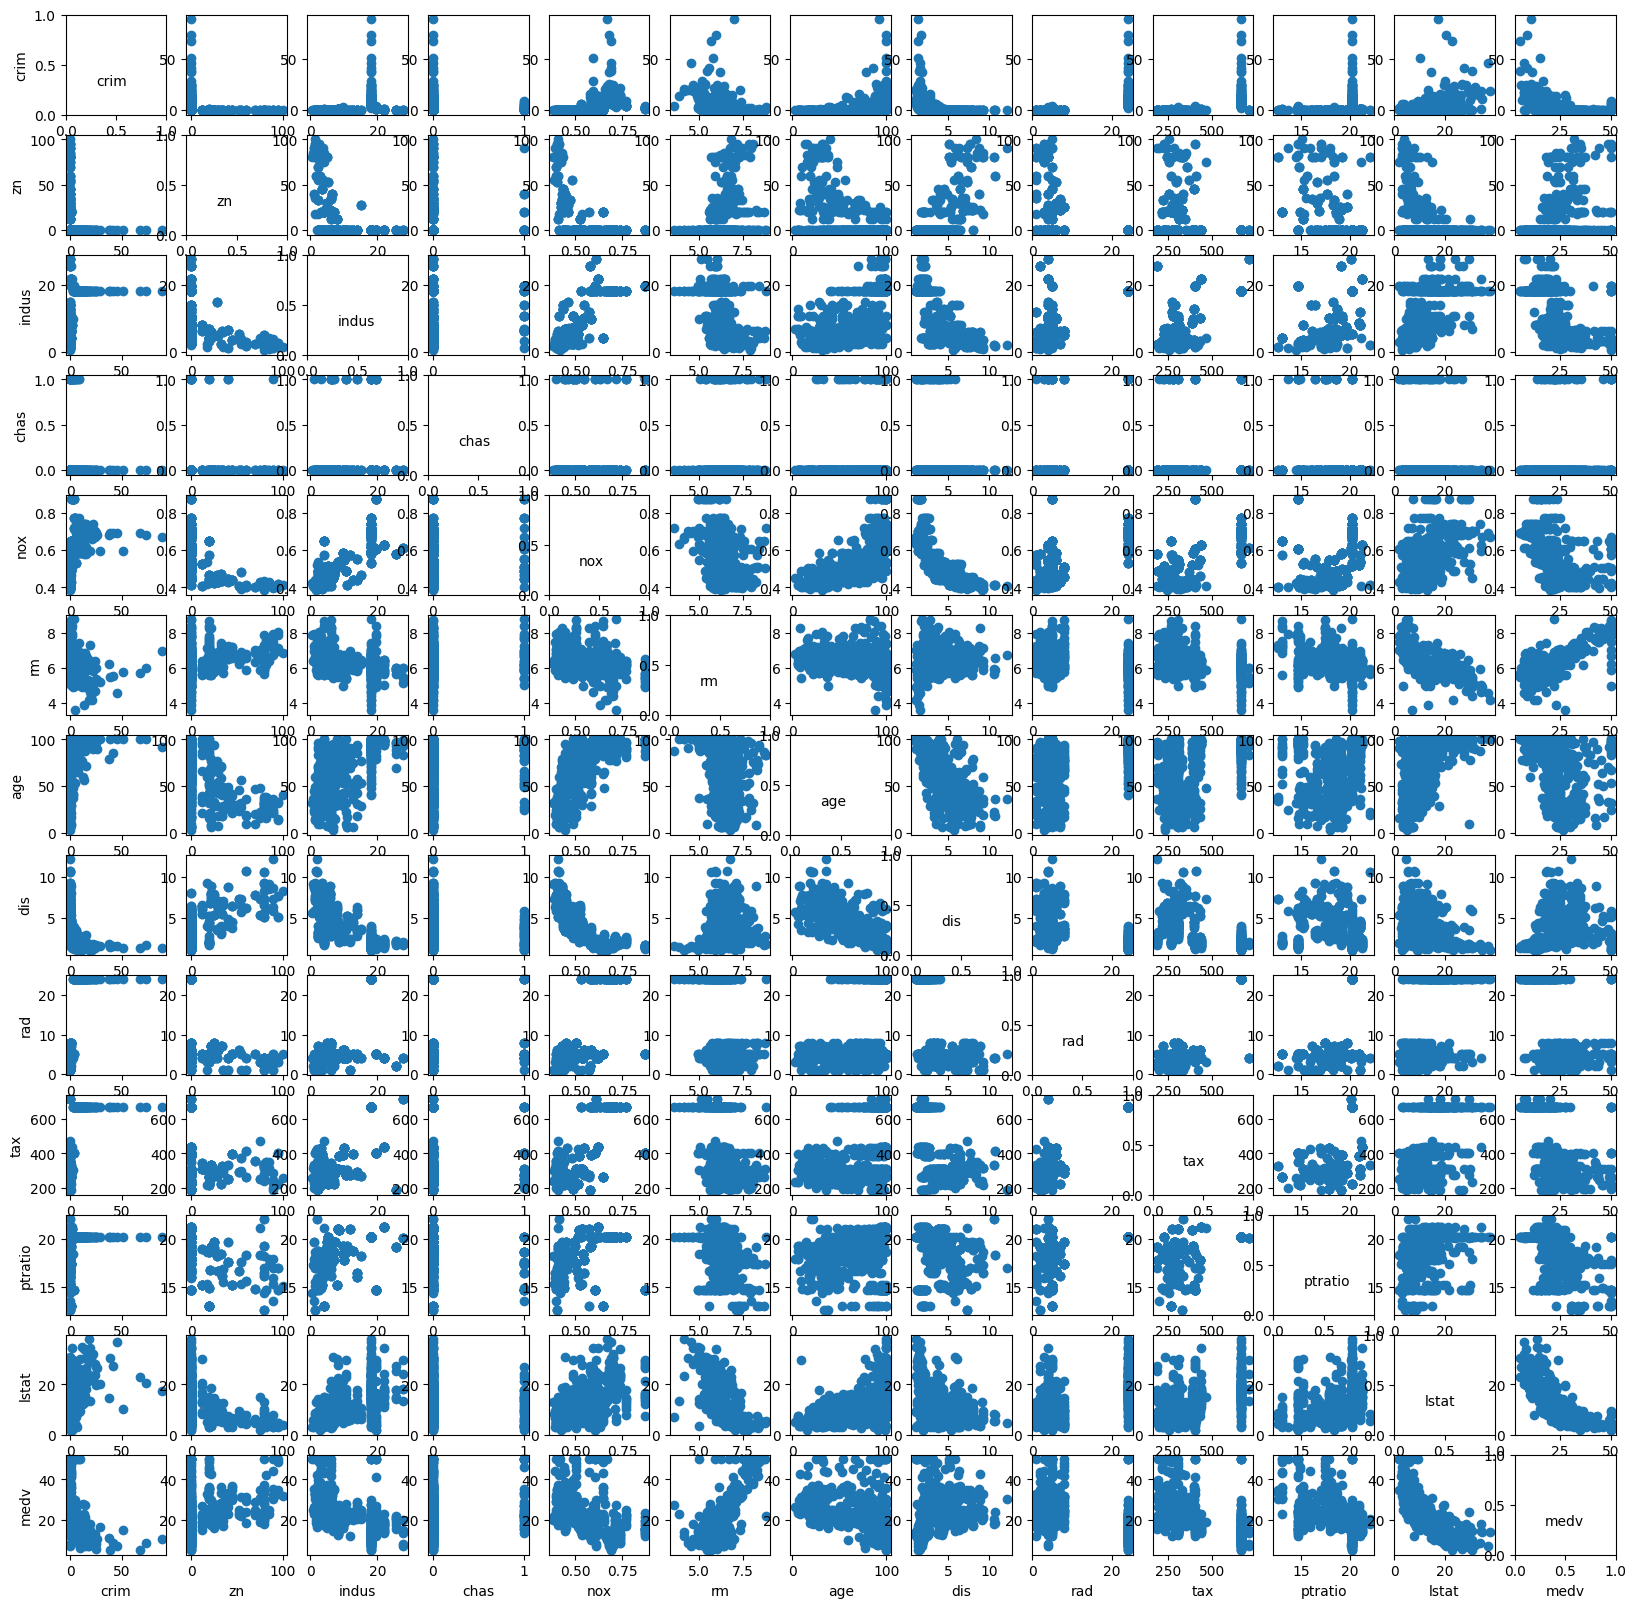

In [246]:
scatter_all(boston, fig_size=20)

In [247]:
for row in boston.columns:
    print(row)

crim
zn
indus
chas
nox
rm
age
dis
rad
tax
ptratio
lstat
medv


In [248]:
len(boston.columns)

13

In [249]:
X = pd.DataFrame({'intercept': np.ones(boston.shape[0]), 'lstat': boston['lstat']})

Why add `intercept` key with an array of `1`'s:  According to the documentation for `statsmodels.regression.linear_model.OLS` found [here](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS):

exog: array_like
A nobs x k array where nobs is the number of observations and k is the number of regressors. An intercept is not included by default and should be added by the user. See statsmodels.tools.add_constant.

If it is not `1`'s it will not properly calculate the coefficient. 

You can also use the following to add a constant:  `sm.add_constant` returns a `pd.DataFrame`

If you don't do sm.add_constant then statsmodels algorithms assume that b=0 in y = mx + b, and it'll fit the model using b=0 instead of calculating what b is supposed to be based on your data.

In [250]:
X = sm.add_constant(boston[['lstat']])

In [251]:
X.head()

,const,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


In [252]:
y = boston['medv']

In [253]:
model = sm.OLS(y,X)
results = model.fit()

In [254]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           5.08e-88
Time:                        10:21:51   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [255]:
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,34.5538,0.563,61.415,0.000,33.448,35.659
lstat,-0.9500,0.039,-24.528,0.000,-1.026,-0.874


### Make predictions

In [256]:
new_df = pd.DataFrame({'lstat':[5, 10, 15]})
new_df = sm.add_constant(new_df)
new_df

,const,lstat
0,1.0,5
1,1.0,10
2,1.0,15


In [257]:
predictions = results.get_prediction(new_df)
predictions.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

In [258]:
# Confidence interval
predictions.conf_int(alpha=0.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

In [259]:
# Prediction interval
predictions.conf_int(obs=True, alpha=0.05)

array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

In [260]:
def abline(ax, b, m, *args , **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim , ylim , *args , **kwargs)

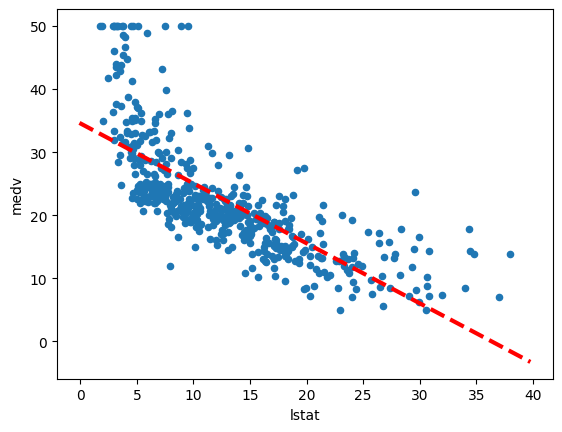

In [261]:
ax = boston.plot.scatter('lstat', 'medv')
abline(ax,
    results.params[0],
    results.params[1],
    'r--',
    linewidth=3)


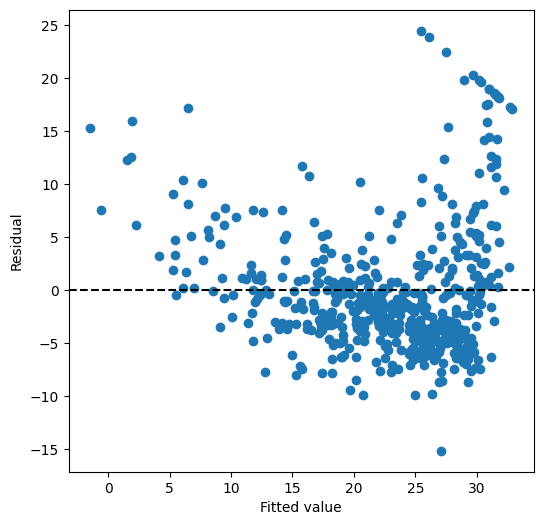

In [262]:
ax = subplots(figsize=(6,6))[1]
ax.scatter(results.fittedvalues , results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

374

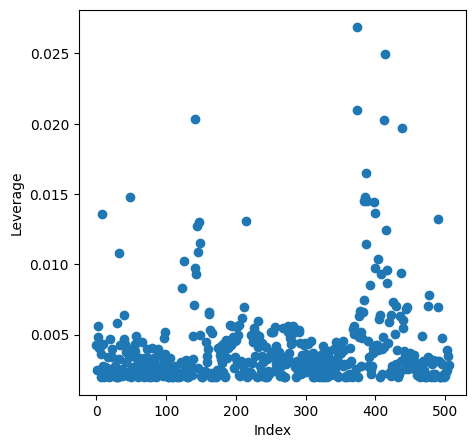

In [263]:
infl = results.get_influence()
ax = subplots(figsize=(5,5))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
# returns the value with the most leverage
np.argmax(infl.hat_matrix_diag)

In [264]:
## Observation with the most leverage
boston[374:375]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
374,18.4982,0.0,18.1,0,0.668,4.138,100.0,1.137,24,666,20.2,37.97,13.8


### Multiple linear regression

In [265]:
X = sm.add_constant(boston[['lstat','age']])
model_1 = sm.OLS(y, X)
results_1 = model_1.fit()
results_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,33.2228,0.731,45.458,0.000,31.787,34.659
lstat,-1.0321,0.048,-21.416,0.000,-1.127,-0.937
age,0.0345,0.012,2.826,0.005,0.011,0.059


#### Use all the variables

In [266]:
X = sm.add_constant(boston[boston.columns.drop('medv')])
model_2 = sm.OLS(y, X)
results_2 = model_2.fit()
results_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,41.6173,4.936,8.431,0.000,31.919,51.316
crim,-0.1214,0.033,-3.678,0.000,-0.186,-0.057
zn,0.0470,0.014,3.384,0.001,0.020,0.074
indus,0.0135,0.062,0.217,0.829,-0.109,0.136
chas,2.8400,0.870,3.264,0.001,1.131,4.549
nox,-18.7580,3.851,-4.870,0.000,-26.325,-11.191
rm,3.6581,0.420,8.705,0.000,2.832,4.484
age,0.0036,0.013,0.271,0.787,-0.023,0.030
dis,-1.4908,0.202,-7.394,0.000,-1.887,-1.095
rad,0.2894,0.067,4.325,0.000,0.158,0.421


In [267]:
results.rsquared

0.5441462975864799

#### Making an interaction term

$$ \hat{y}_i = \hat{\beta_0} + \hat{\beta_1}x_{i,1} + \hat{\beta_2}x_{i,2} + \hat{\beta_3}x_{i,1}*x_{i,2}$$

Unlike in R, you need to add the column to your dataframe.

In [268]:
boston['lstat:age']=boston.lstat*boston.age

In [269]:
X = sm.add_constant(boston[['lstat','age','lstat:age']])

In [270]:
X.head()

,const,lstat,age,lstat:age
0,1.0,4.98,65.2,324.696
1,1.0,9.14,78.9,721.146
2,1.0,4.03,61.1,246.233
3,1.0,2.94,45.8,134.652
4,1.0,5.33,54.2,288.886


In [271]:
model_3 = sm.OLS(y, X)
results_3 = model_3.fit()
results_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,36.0885,1.470,24.553,0.000,33.201,38.976
lstat,-1.3921,0.167,-8.313,0.000,-1.721,-1.063
age,-0.0007,0.020,-0.036,0.971,-0.040,0.038
lstat:age,0.0042,0.002,2.244,0.025,0.001,0.008


#### Fit a model with a square term

In [272]:
boston['lstat^2']=np.square(boston.lstat)

In [273]:
X = sm.add_constant(boston[['lstat','lstat^2','age']])
model_4 = sm.OLS(y, X)
results_4 = model_4.fit()
results_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,41.2885,0.873,47.284,0.000,39.573,43.004
lstat,-2.6883,0.131,-20.502,0.000,-2.946,-2.431
lstat^2,0.0495,0.004,13.315,0.000,0.042,0.057
age,0.0703,0.011,6.471,0.000,0.049,0.092


In [274]:
anova_lm(results_1,results_4)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,503.0,19168.128609,0.0,NaN,NaN,NaN
1,502.0,14165.613251,1.0,5002.515357,177.278785,7.468491e-35


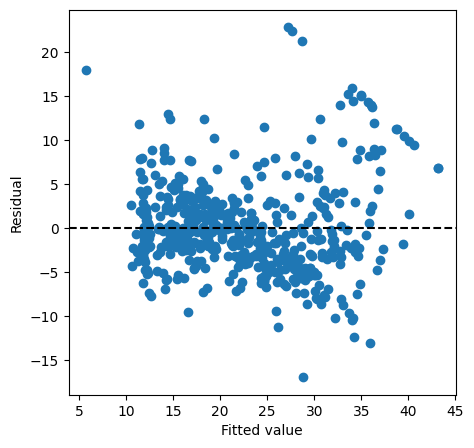

In [275]:
ax = subplots(figsize=(5,5))[1]
ax.scatter(results_4.fittedvalues , results_4.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

### Using qualitative explanatory variables

In [276]:
carseats = load_data('Carseats')

In [277]:
list(carseats.columns)

['Sales',
 'CompPrice',
 'Income',
 'Advertising',
 'Population',
 'Price',
 'ShelveLoc',
 'Age',
 'Education',
 'Urban',
 'US']

In [278]:
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In `carseats`  there are three categorical variables:  `ShelveLoc`, `Urban`, `US`.  These need to be encoded with a 1 or 0, known to some as `one-hot encoding`.  `ShelveLoc` has three possible categories: `Bad`, `Good`, and `Medium`, we do not need to have coefficents for each category, so we drop bad because if $x_{i, good} = 0$ and $x_{i, medium} = 0$ then we know the category is `Bad`. Pandas makes this easy

In [279]:
#categorical data
categorical_cols = ['ShelveLoc', 'Urban', 'US'] 
carseats = pd.get_dummies(carseats, columns = categorical_cols, drop_first=True)
## or do it manually
# df = pd.get_dummies(carseats, columns = categorical_cols).drop(columns = ['Urban_No', 'US_No', 'ShelveLoc_Bad'])

In [280]:
## Add interaction terms
carseats['Income:Advertising'] = carseats.Income*carseats.Advertising
carseats['Price:Age'] = carseats.Price*carseats.Age

In [281]:
all_variables = list(carseats.columns.drop('Sales'))
response = carseats['Sales']
X = sm.add_constant(carseats[all_variables])
model_carseats = sm.OLS(response, X)
results_carseats = model_carseats.fit()

In [282]:
results_carseats.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,6.5756,1.009,6.519,0.000,4.592,8.559
CompPrice,0.0929,0.004,22.567,0.000,0.085,0.101
Income,0.0109,0.003,4.183,0.000,0.006,0.016
Advertising,0.0702,0.023,3.107,0.002,0.026,0.115
Population,0.0002,0.000,0.433,0.665,-0.001,0.001
Price,-0.1008,0.007,-13.549,0.000,-0.115,-0.086
Age,-0.0579,0.016,-3.633,0.000,-0.089,-0.027
Education,-0.0209,0.020,-1.063,0.288,-0.059,0.018
ShelveLoc_Good,4.8487,0.153,31.724,0.000,4.548,5.149
ShelveLoc_Medium,1.9533,0.126,15.531,0.000,1.706,2.201
